In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'VSAT'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-10-01,359,-242,117,24,42,280,127,526,118,...,74,0,1,245,724,1018,112,-64,48.28,2014-11-10
1,2015-01-01,340,-234,106,15,98,268,129,577,117,...,82,0,1,269,819,1134,113,-149,48.28,2015-02-10
2,2015-04-01,365,-251,114,7,52,266,128,491,117,...,77,0,0,268,806,1120,78,-109,48.28,2015-05-31
3,2015-06-30,344,-243,101,2,42,295,127,570,118,...,73,0,0,227,861,1133,18,-83,49.44,2015-08-09
4,2015-09-30,353,-241,113,5,46,305,123,584,117,...,80,0,0,251,859,1154,90,-87,49.44,2015-11-09


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-06-30,2023-08-09,124.05,780,-545,235,-78,1959,631,336,...,2847,17898,378,0,60,1472,7218,11958,104,-375
36,2023-09-30,2023-11-09,124.53,1225,-766,459,-765,1962,664,346,...,3074,17072,389,0,63,1550,7228,11882,219,-366
37,2023-12-31,2024-02-09,125.32,1129,-767,361,-122,1571,676,354,...,3112,16651,315,0,63,1377,7223,11548,134,-421
38,2024-03-31,2024-05-20,125.90,1150,-823,322,-85,1901,678,318,...,2937,16329,287,0,58,1295,7129,11256,232,-378
39,2024-06-30,2024-08-05,126.60,1126,-710,416,-33,1811,694,330,...,2855,16087,230,0,58,1079,7128,11001,0,0


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-06-30,2023-08-09,124.05,780,-545,235,-78,1959,631,336,...,17898,378,0,60,1472,7218,11958,104,-375,1
36,2023-09-30,2023-11-09,124.53,1225,-766,459,-765,1962,664,346,...,17072,389,0,63,1550,7228,11882,219,-366,1
37,2023-12-31,2024-02-09,125.32,1129,-767,361,-122,1571,676,354,...,16651,315,0,63,1377,7223,11548,134,-421,1
38,2024-03-31,2024-05-20,125.90,1150,-823,322,-85,1901,678,318,...,16329,287,0,58,1295,7129,11256,232,-378,1
39,2024-06-30,2024-08-05,126.60,1126,-710,416,-33,1811,694,330,...,16087,230,0,58,1079,7128,11001,0,0,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-06-30,2023-08-09,124.05,780.0,-545.0,235.0,-78.0,1959.0,631.0,336.0,...,17898.0,378.0,0.0,60.0,1472.0,7218.0,11958.0,104.0,-375.0,1
36,2023-09-30,2023-11-09,124.53,1225.0,-766.0,459.0,-765.0,1962.0,664.0,346.0,...,17072.0,389.0,0.0,63.0,1550.0,7228.0,11882.0,219.0,-366.0,1
37,2023-12-31,2024-02-09,125.32,1129.0,-767.0,361.0,-122.0,1571.0,676.0,354.0,...,16651.0,315.0,0.0,63.0,1377.0,7223.0,11548.0,134.0,-421.0,1
38,2024-03-31,2024-05-20,125.90,1150.0,-823.0,322.0,-85.0,1901.0,678.0,318.0,...,16329.0,287.0,0.0,58.0,1295.0,7129.0,11256.0,232.0,-378.0,1
39,2024-06-30,2024-08-05,126.60,1126.0,-710.0,416.0,-33.0,1811.0,694.0,330.0,...,16087.0,230.0,0.0,58.0,1079.0,7128.0,11001.0,0.0,0.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-10,67.610001,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.494789,0.505211,0.0,0.0,0.0,0.0,0.325905,0.066852,0.0,0.0
1,2014-11-17,66.139999,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.494789,0.505211,0.0,0.0,0.0,0.0,0.325905,0.066852,0.0,0.0
2,2014-11-24,66.300003,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.494789,0.505211,0.0,0.0,0.0,0.0,0.325905,0.066852,0.0,0.0
3,2014-12-01,66.150002,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.494789,0.505211,0.0,0.0,0.0,0.0,0.325905,0.066852,0.0,0.0
4,2014-12-08,62.660000,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.494789,0.505211,0.0,0.0,0.0,0.0,0.325905,0.066852,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-10,67.610001,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.0,0.325905,0.066852,0.0,0.0,inf,3.274033,inf,inf,inf
1,2014-11-17,66.139999,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.0,0.325905,0.066852,0.0,0.0,inf,3.202848,inf,inf,inf
2,2014-11-24,66.300003,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.0,0.325905,0.066852,0.0,0.0,inf,3.210596,inf,inf,inf
3,2014-12-01,66.150002,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.0,0.325905,0.066852,0.0,0.0,inf,3.203332,inf,inf,inf
4,2014-12-08,62.660000,2014-10-01,359.0,0.0,20.650373,48.28,0.0,0.0,42.0,...,0.0,0.325905,0.066852,0.0,0.0,inf,3.034328,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

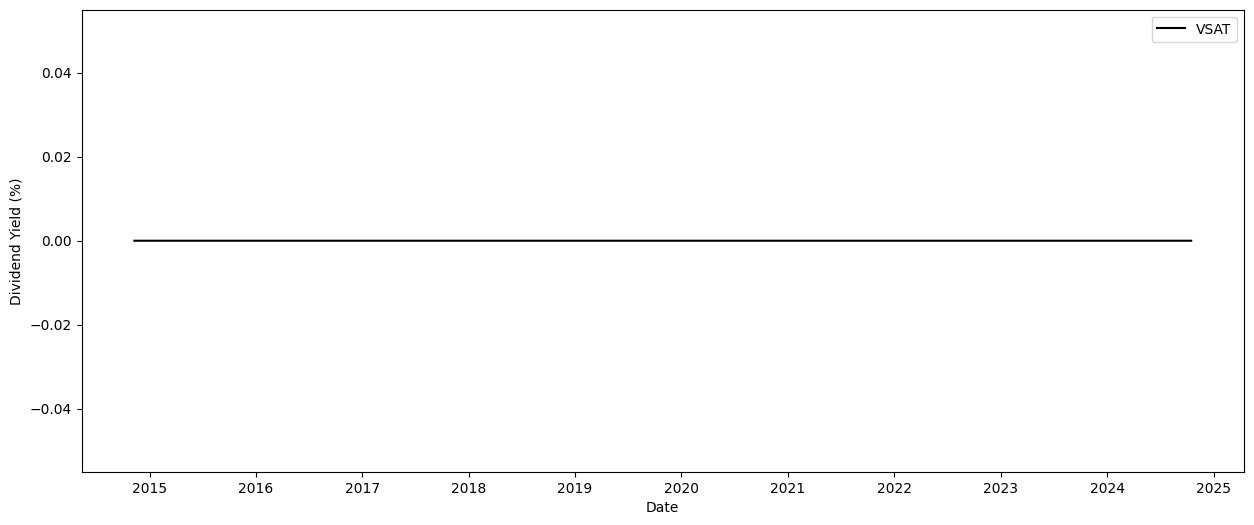

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


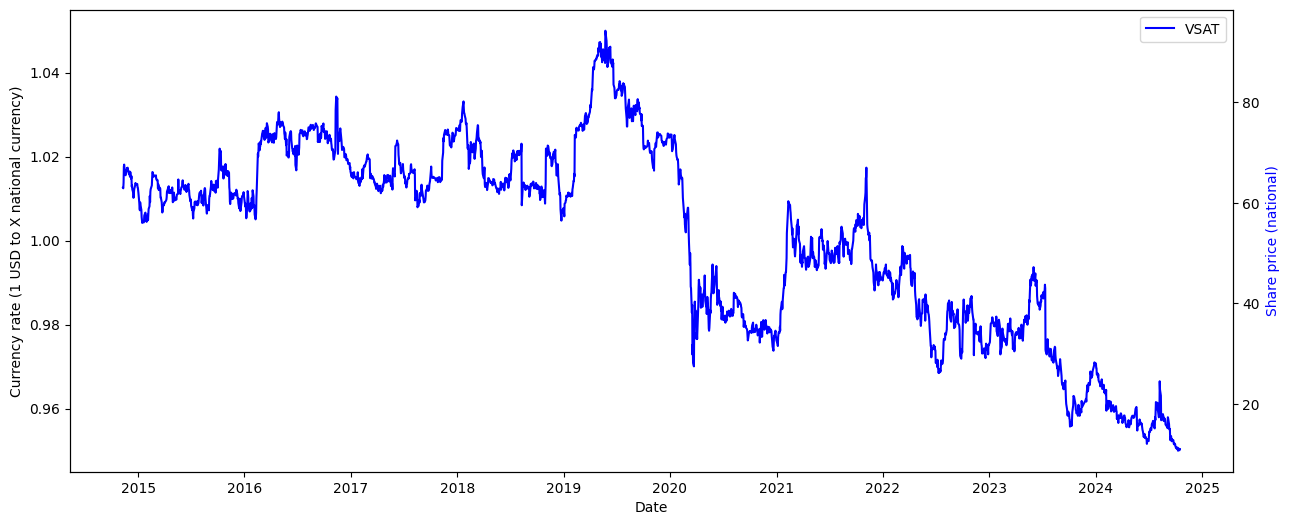

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

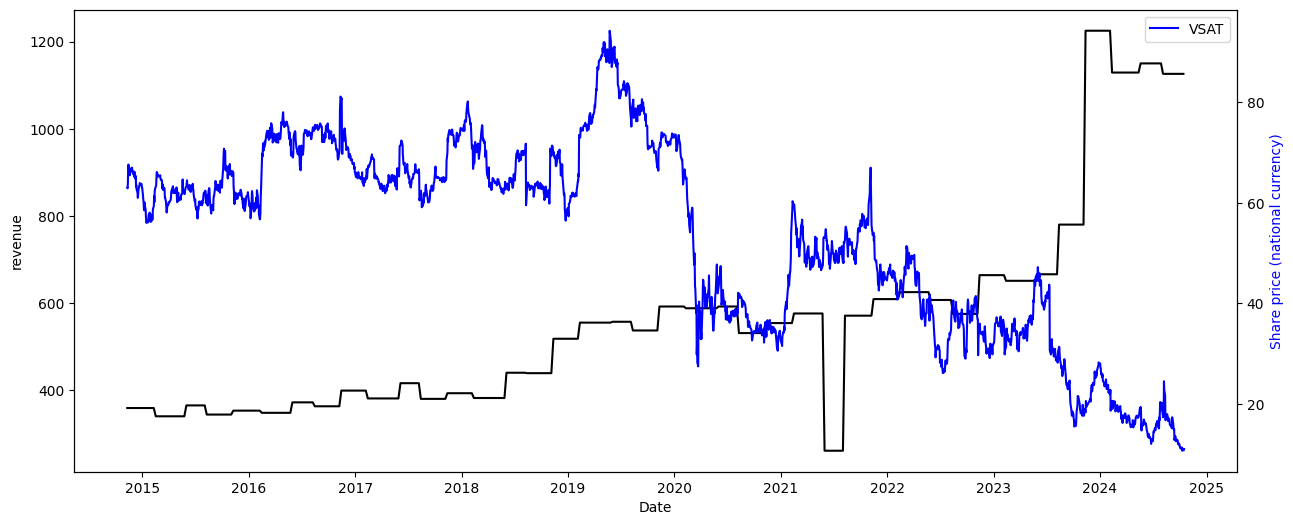

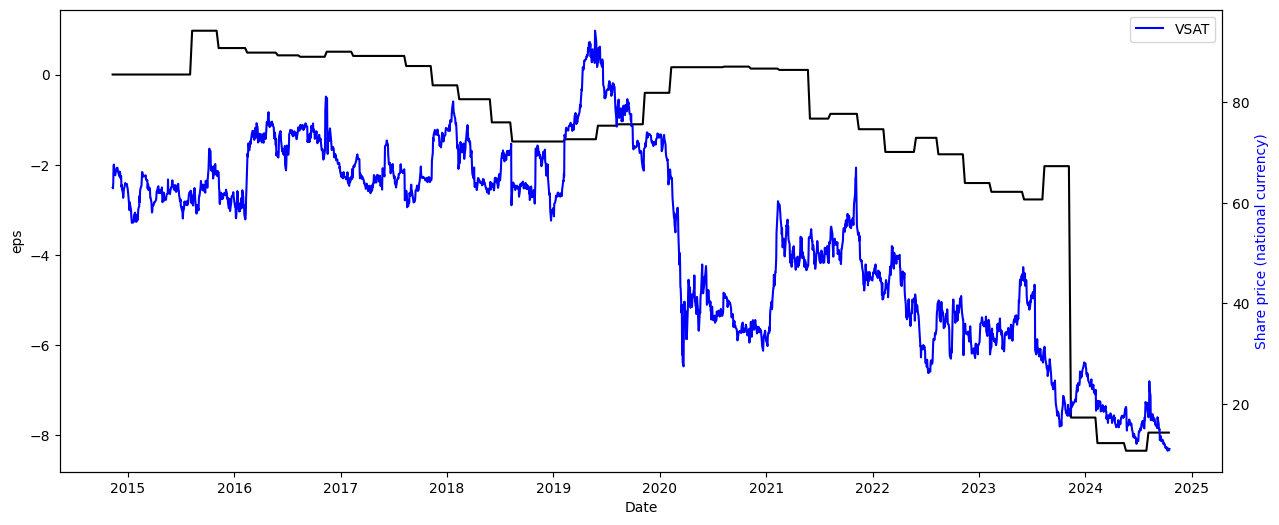

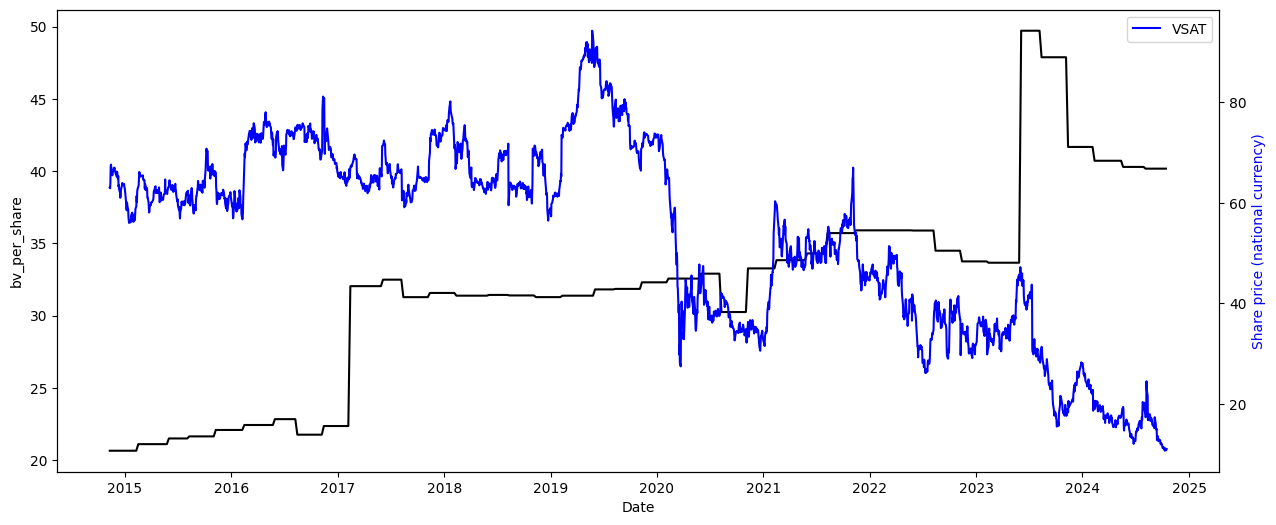

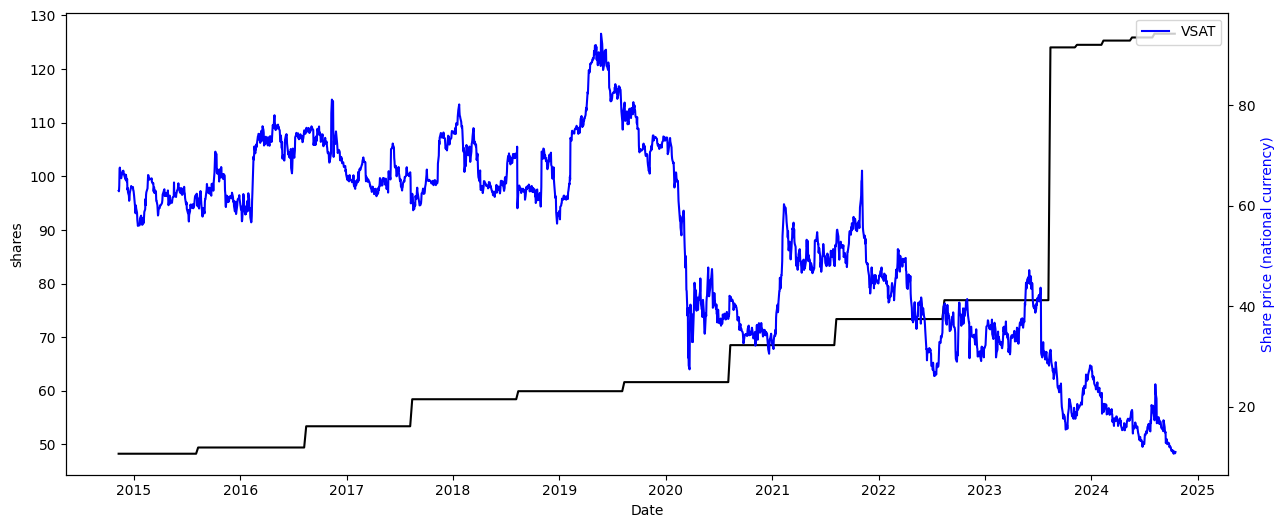

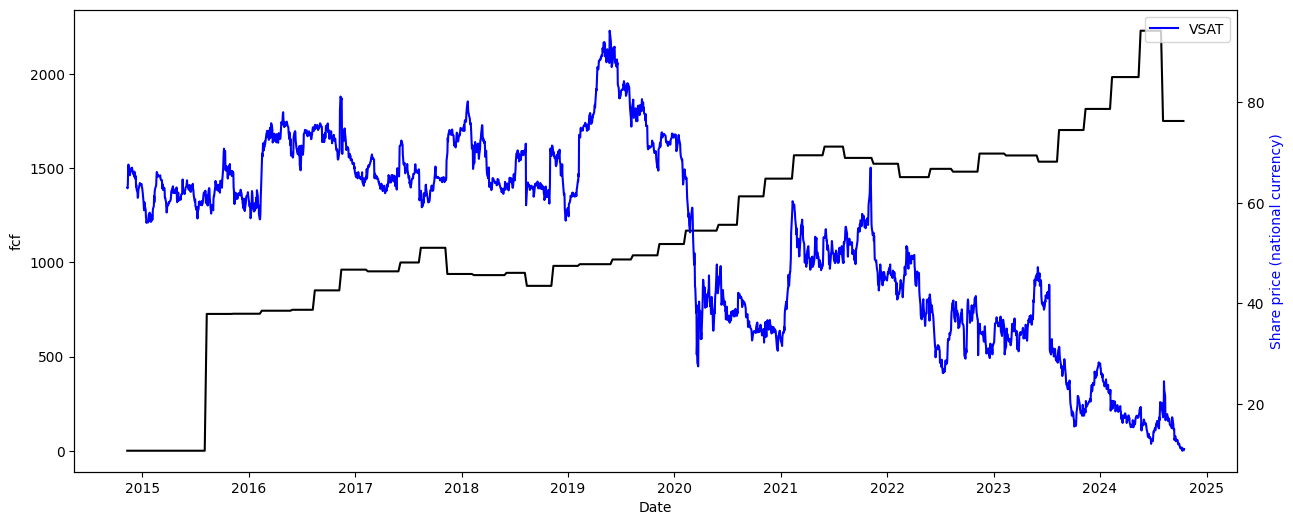

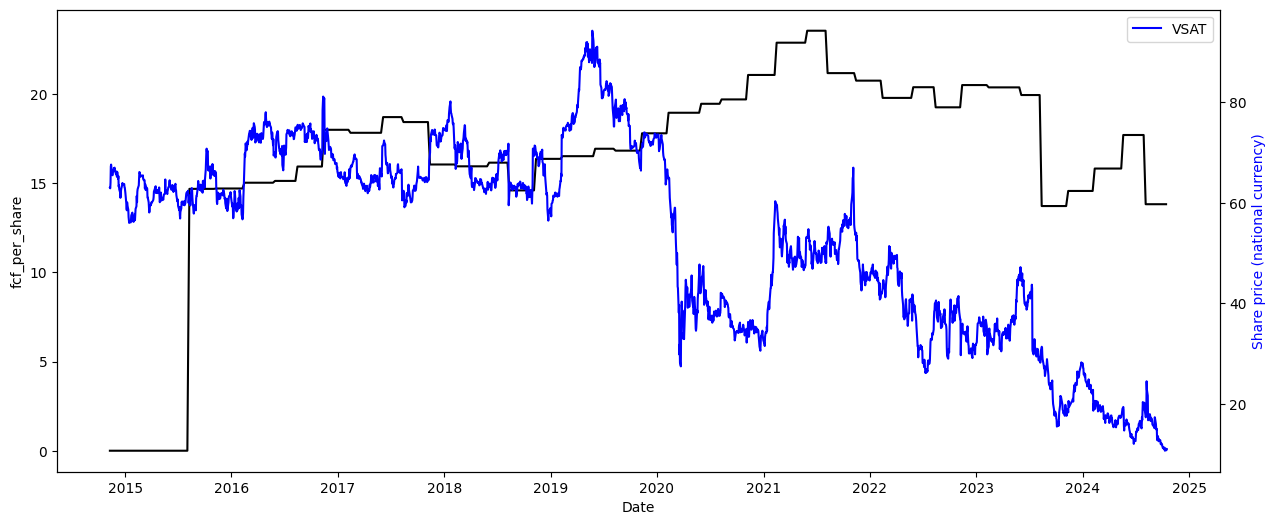

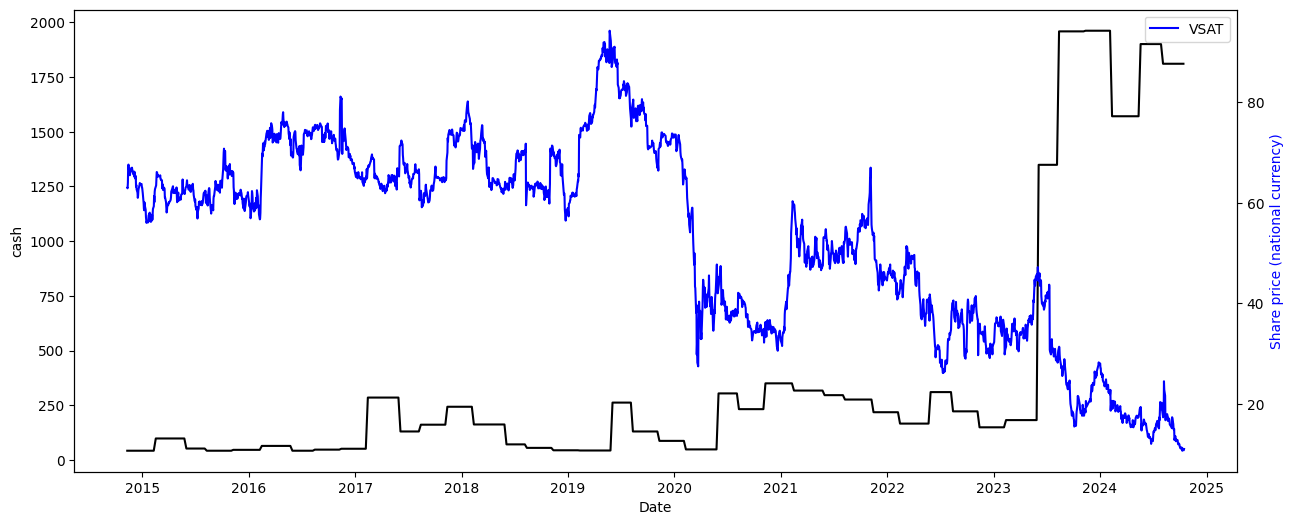

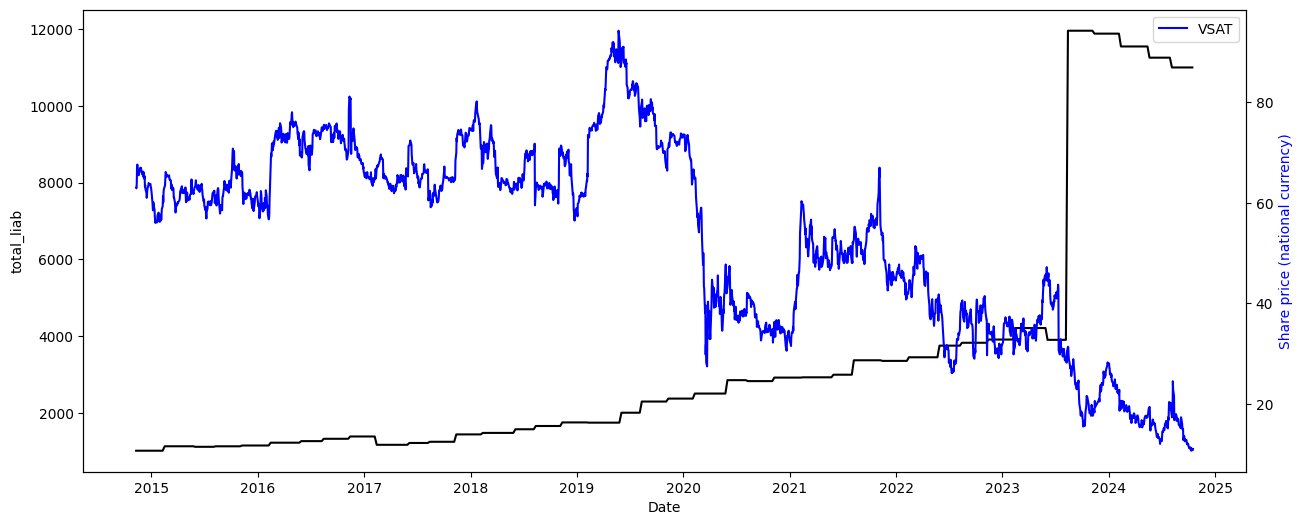

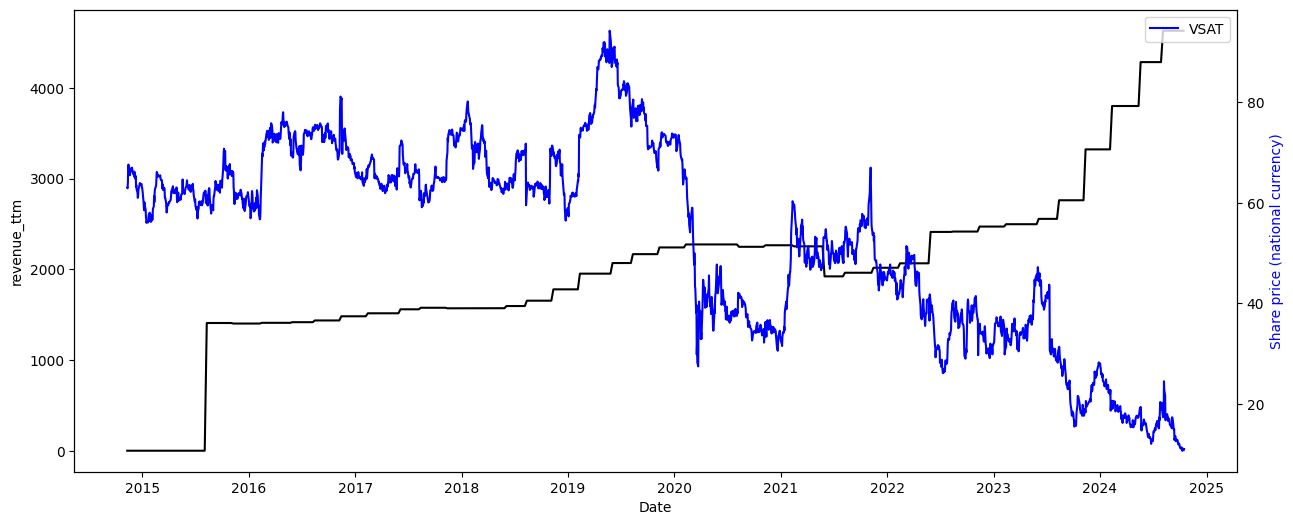

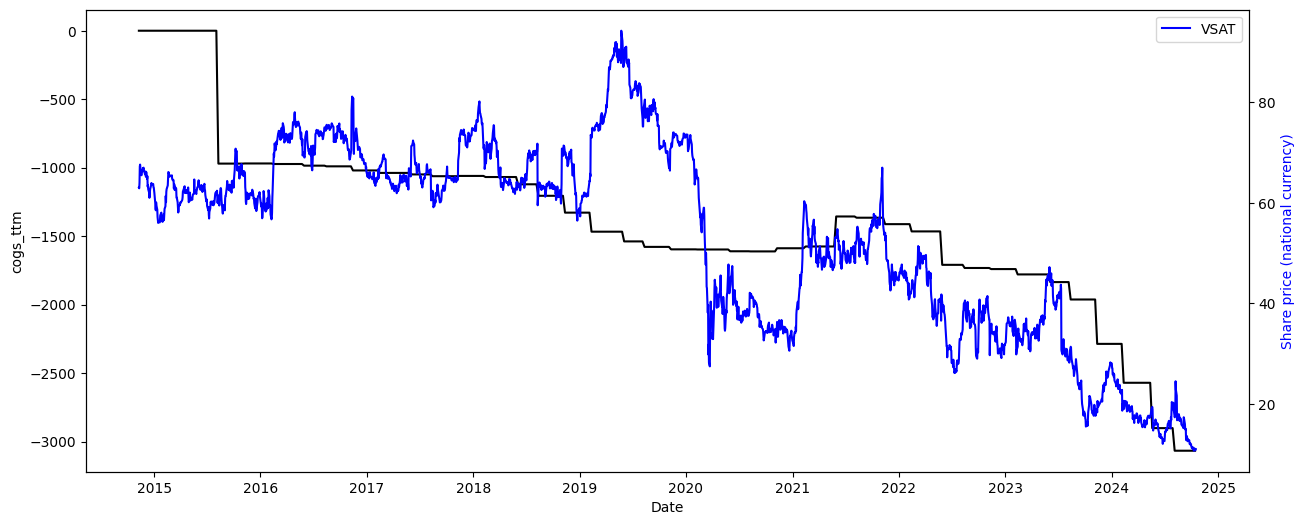

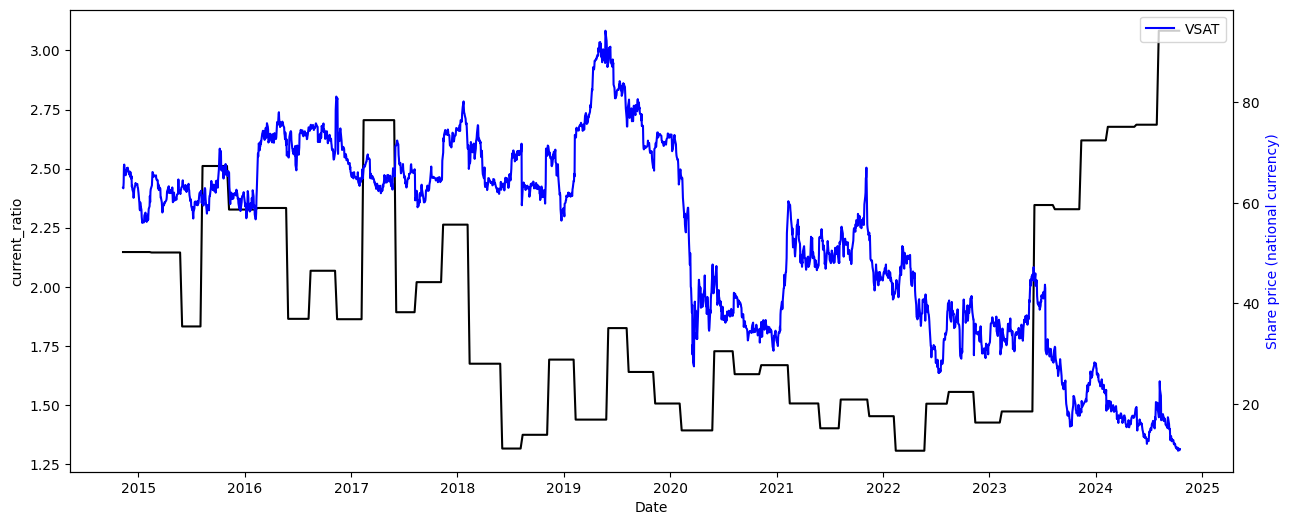

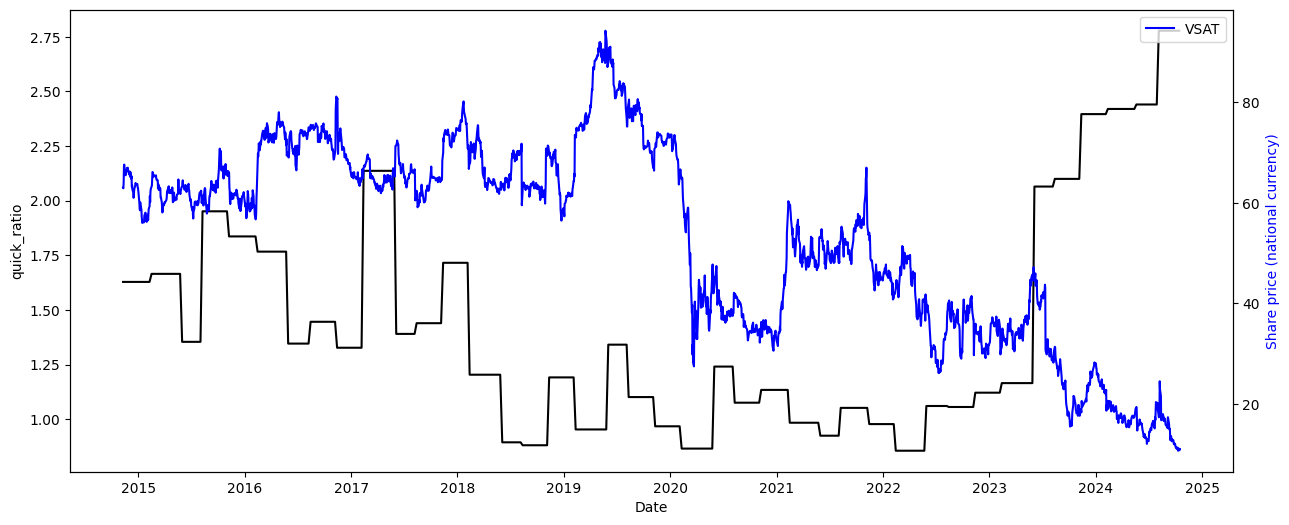

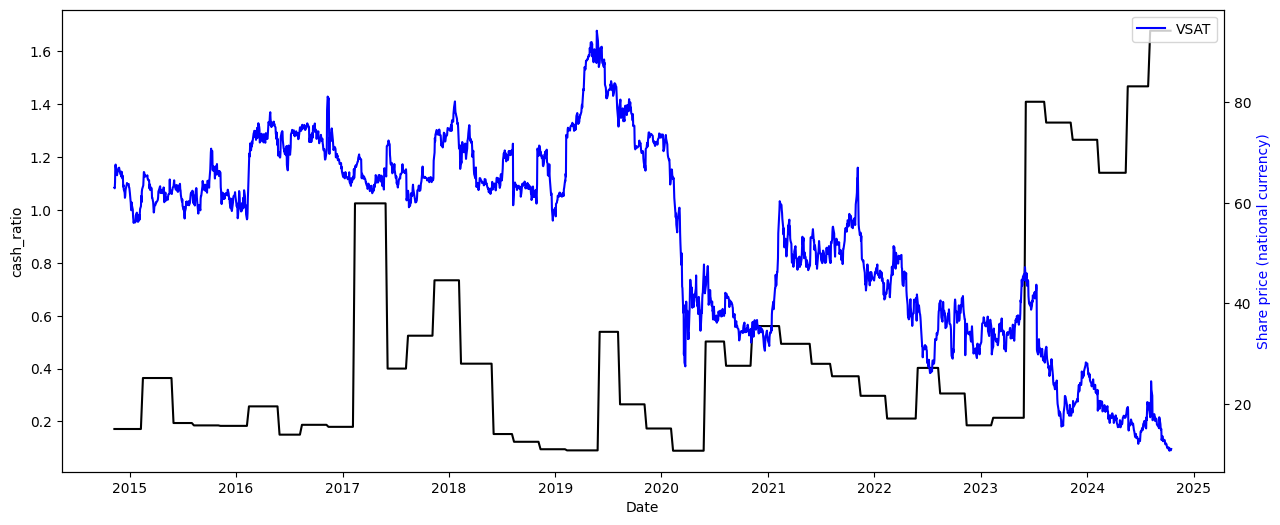

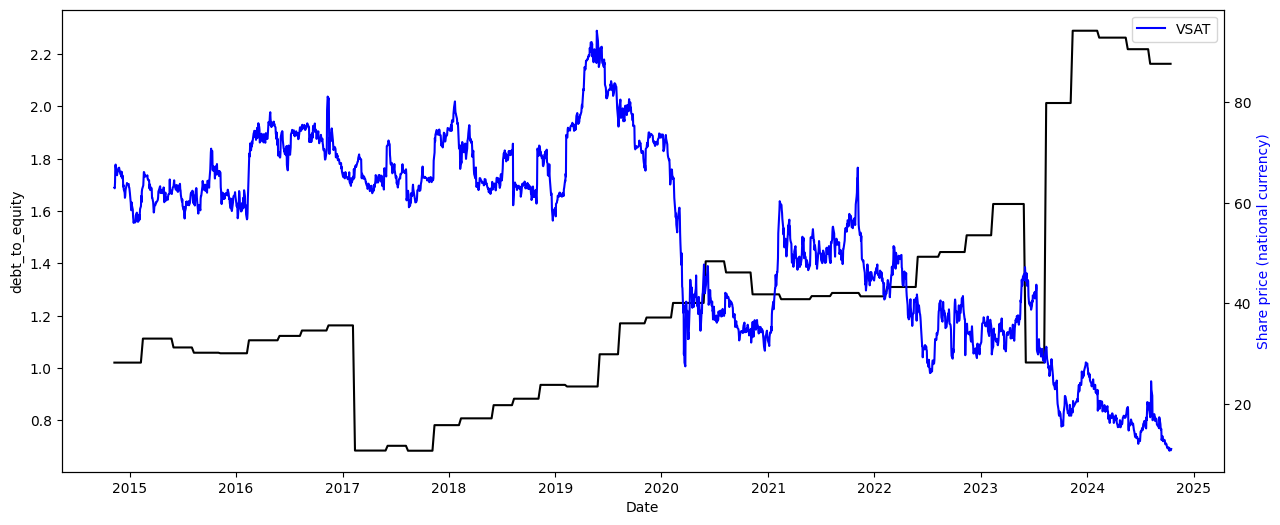

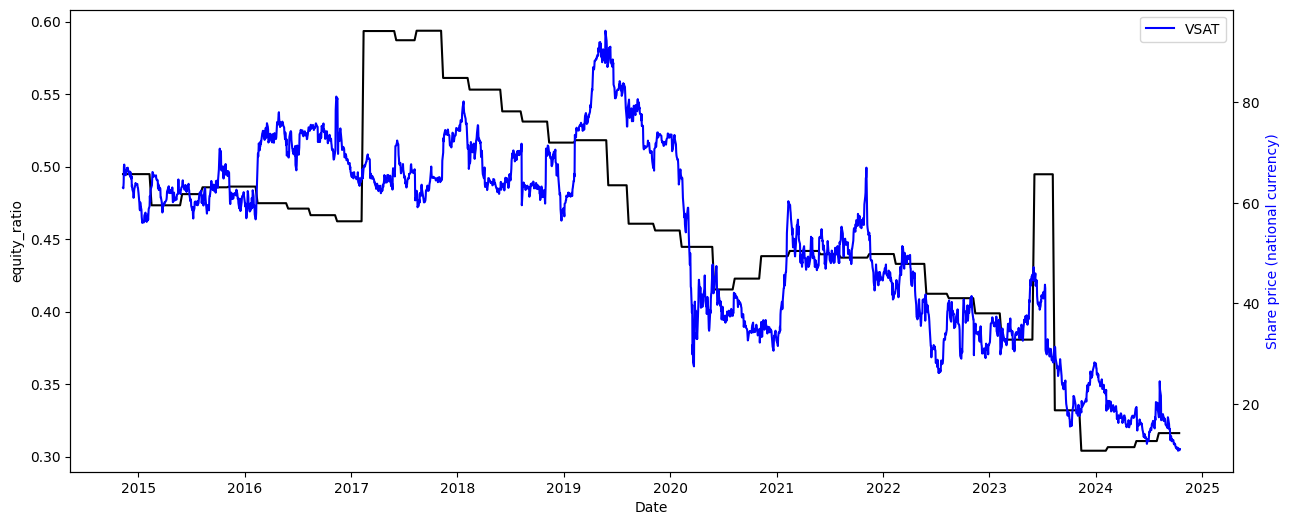

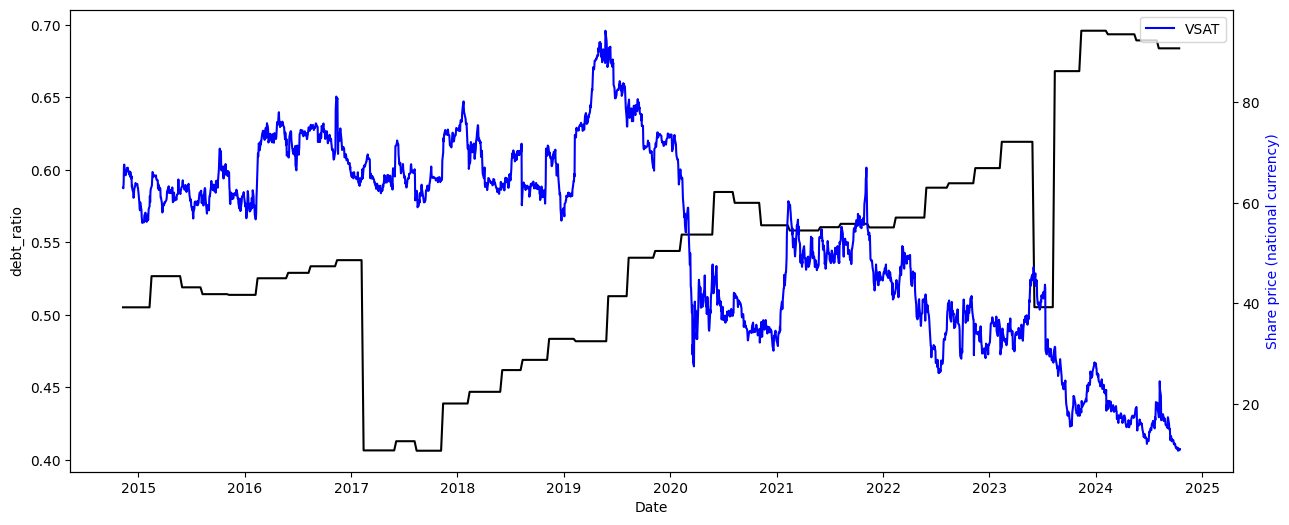

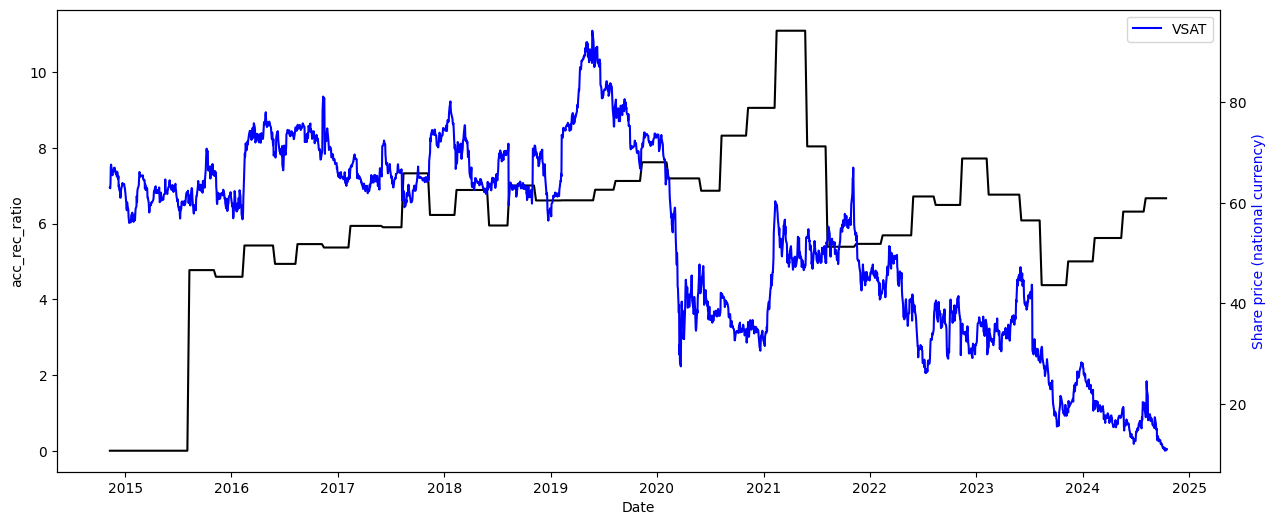

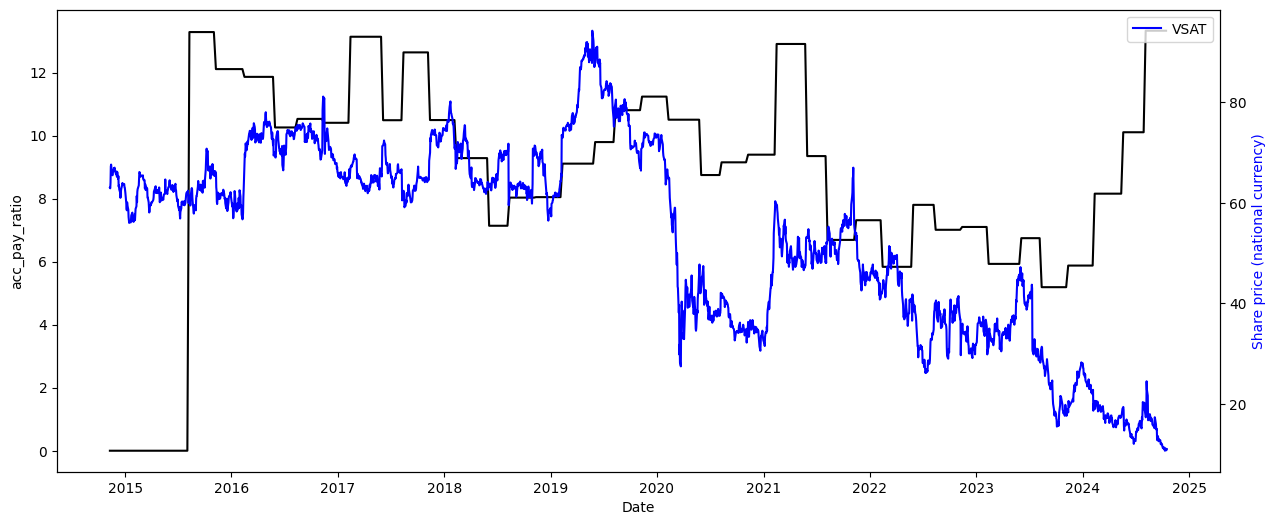

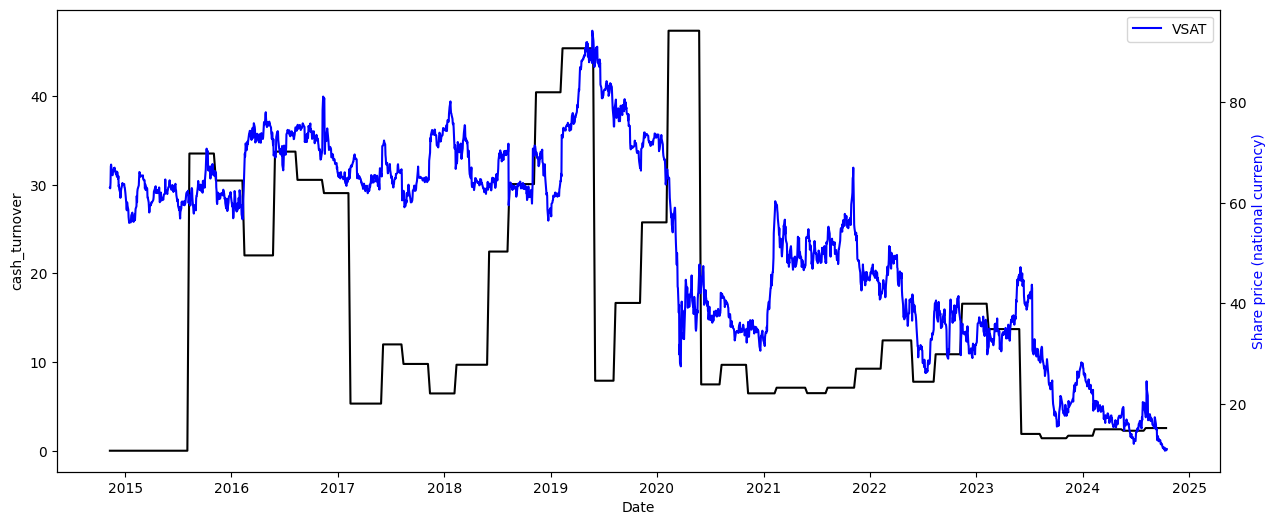

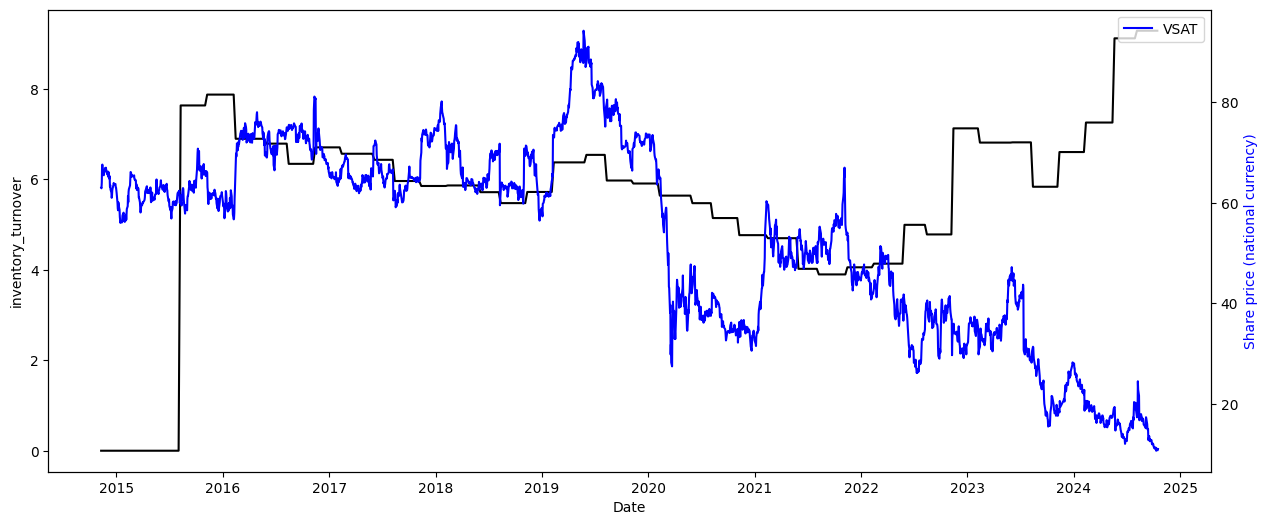

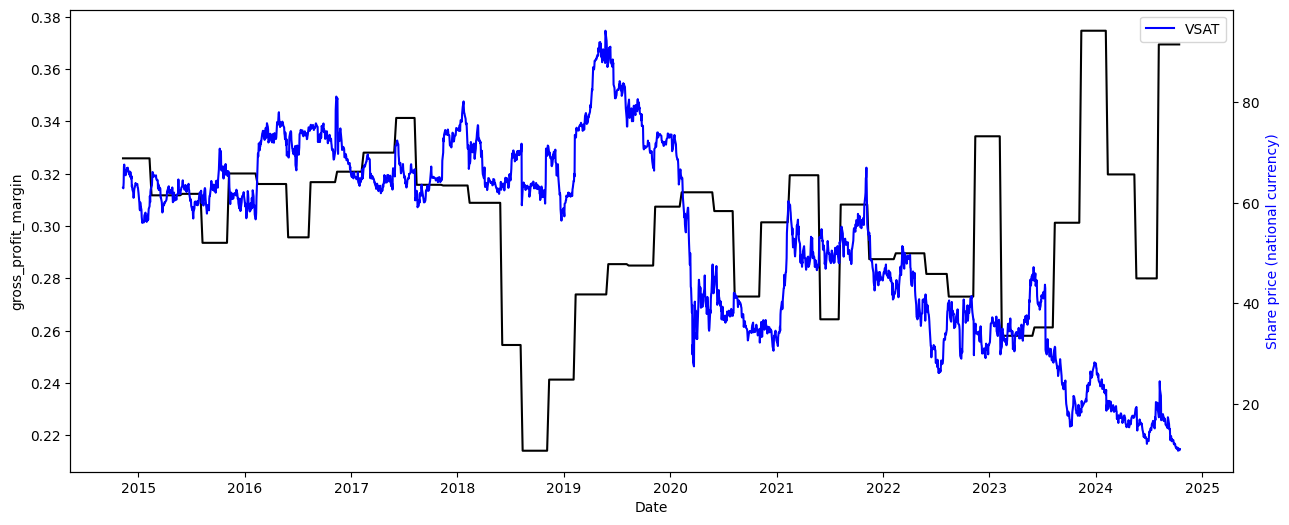

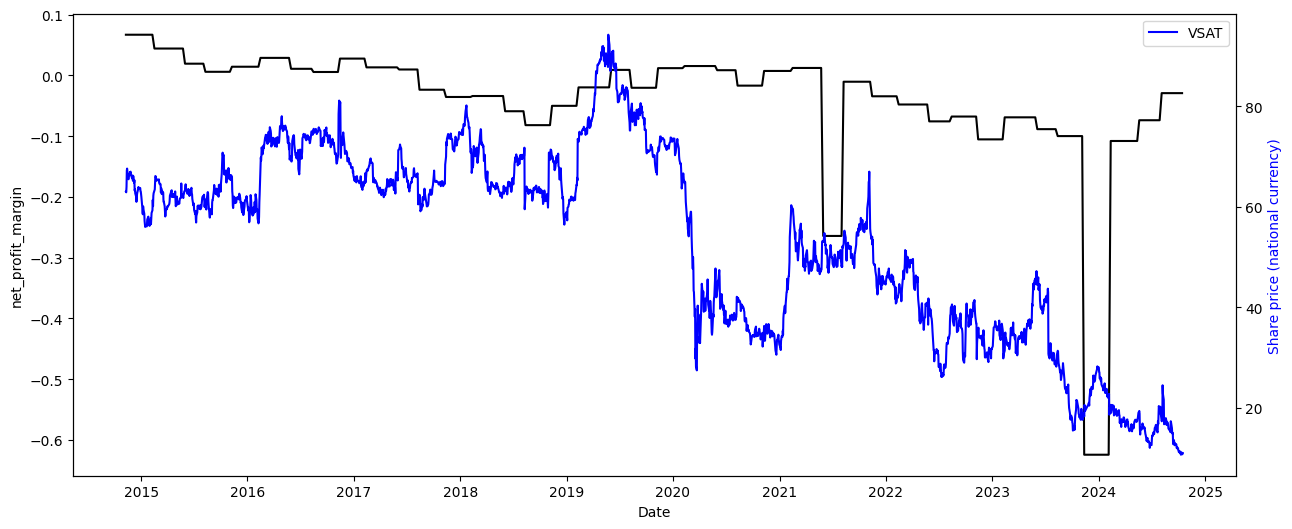

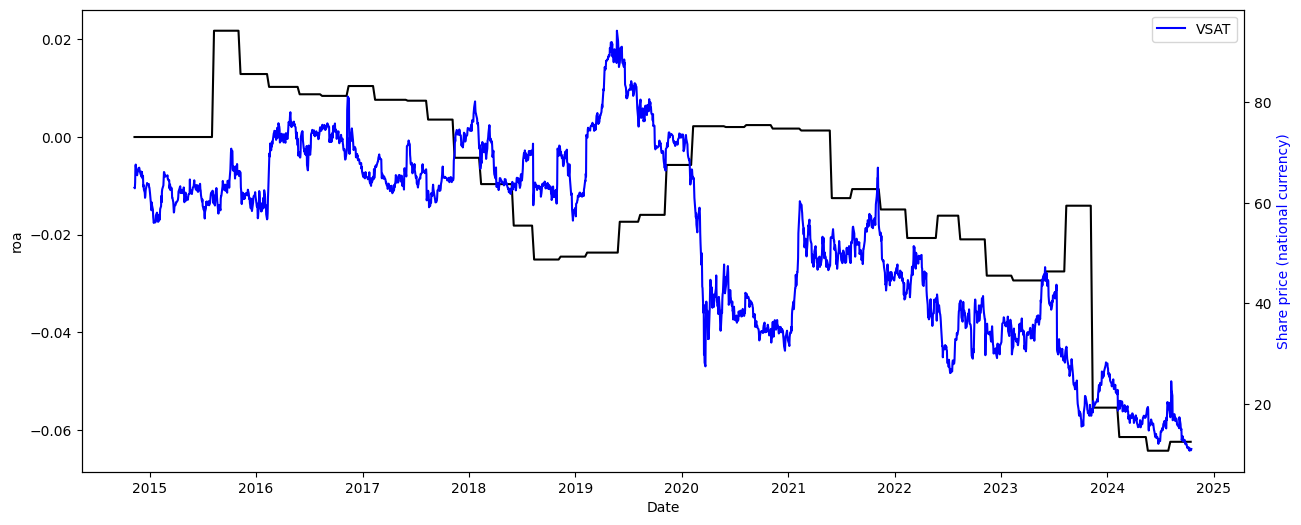

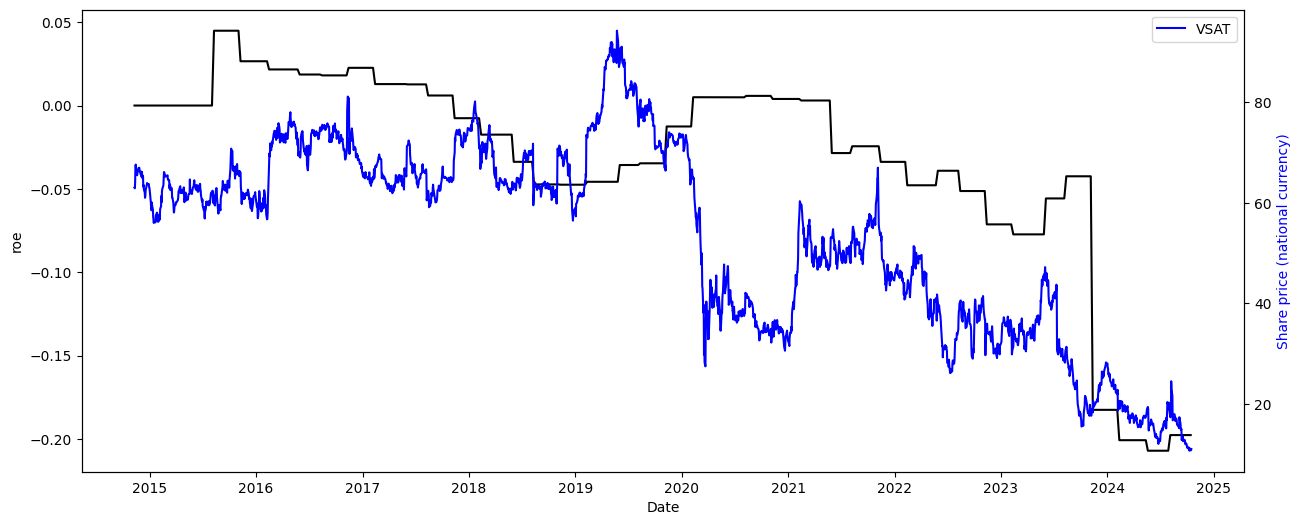

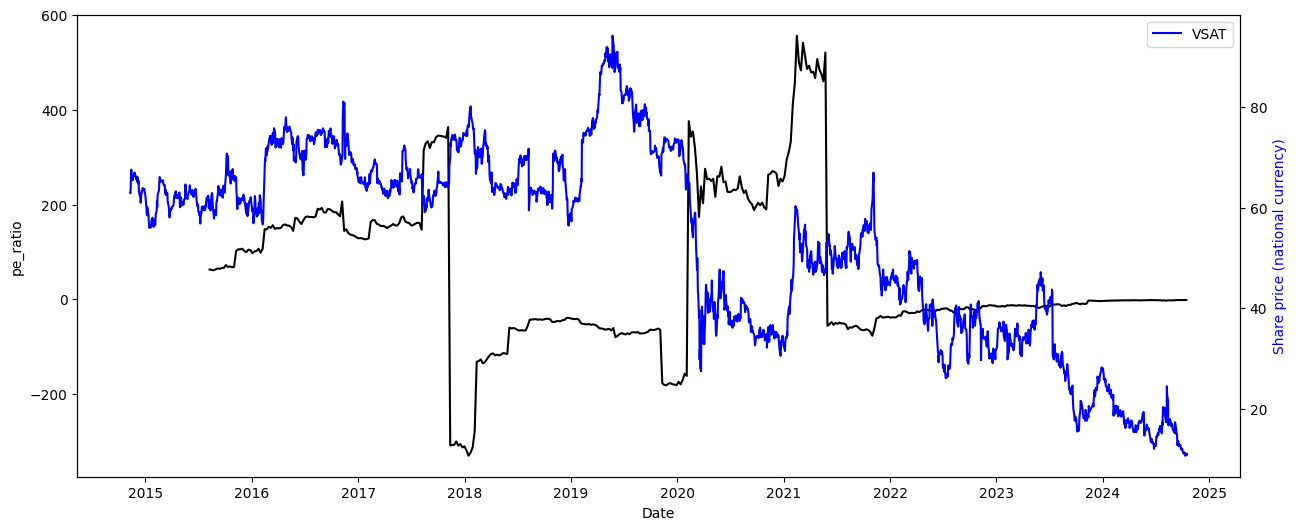

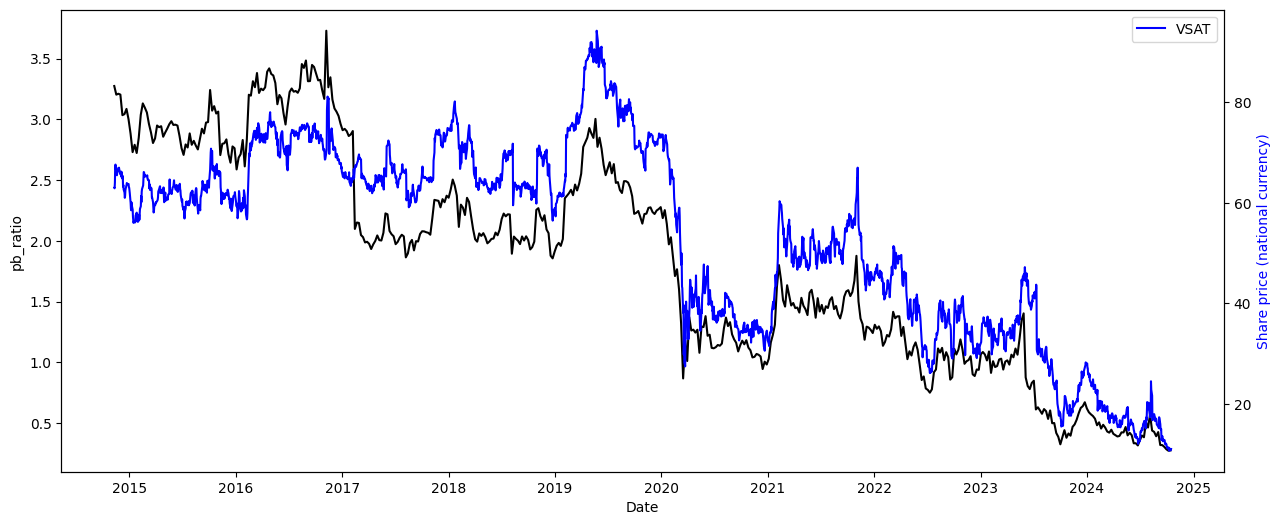

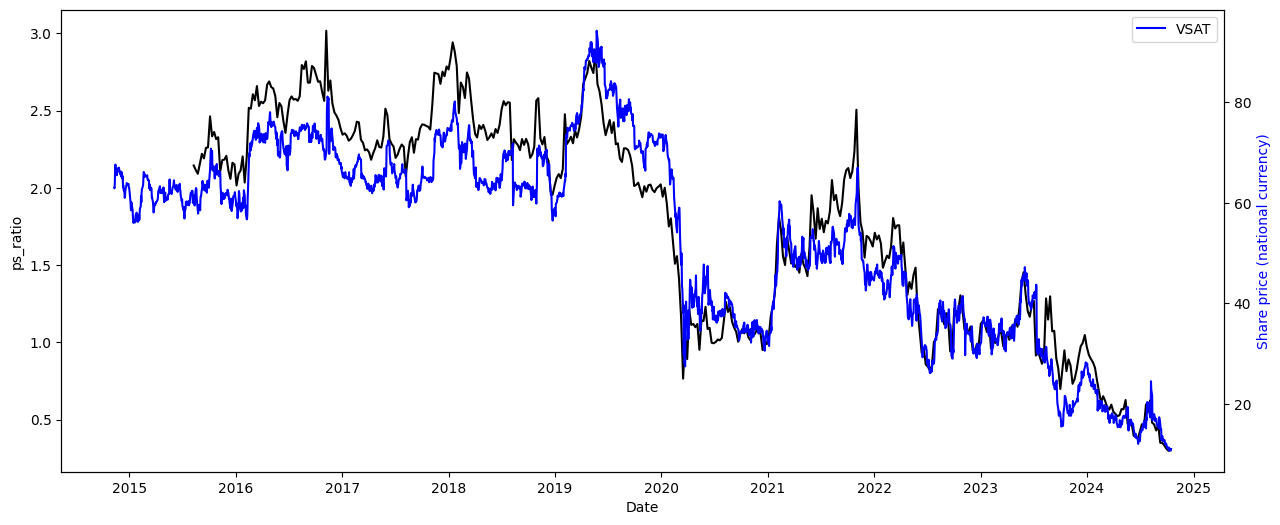

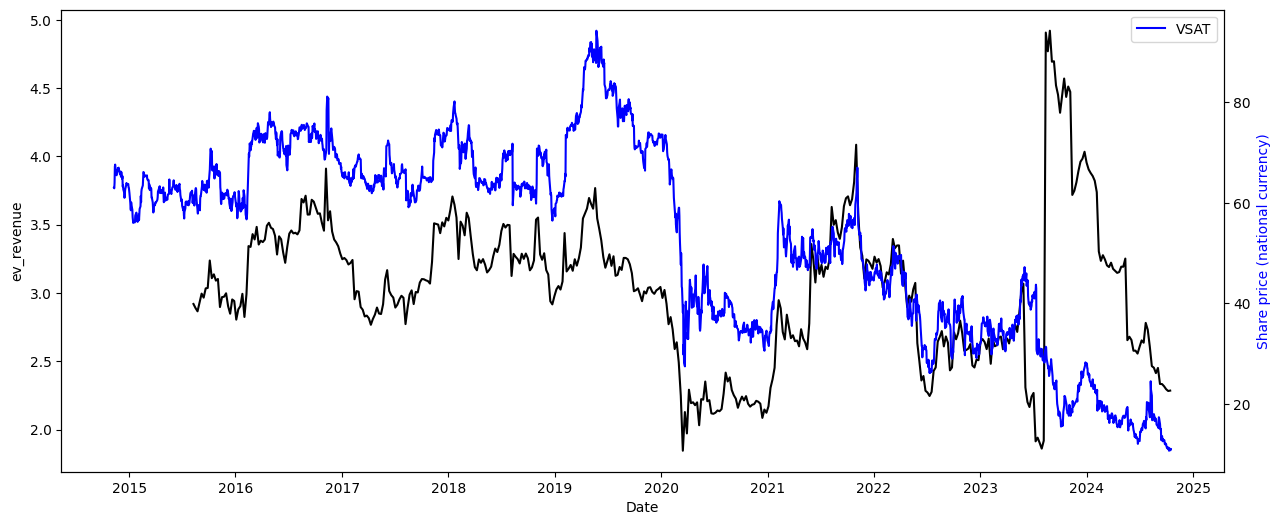

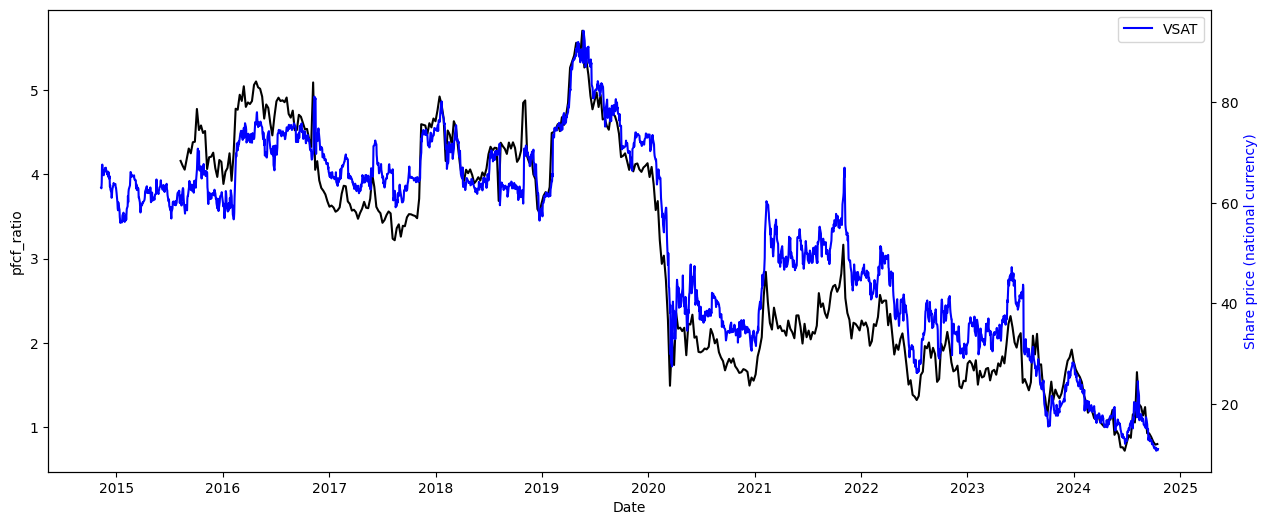

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

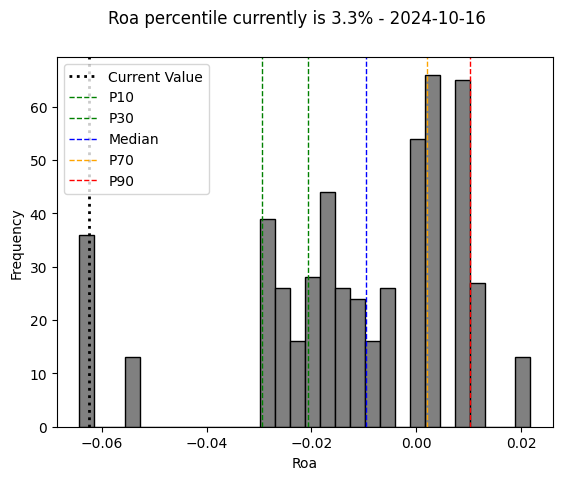

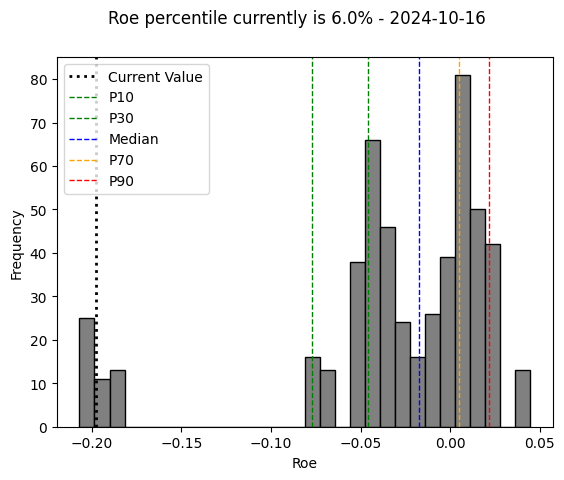

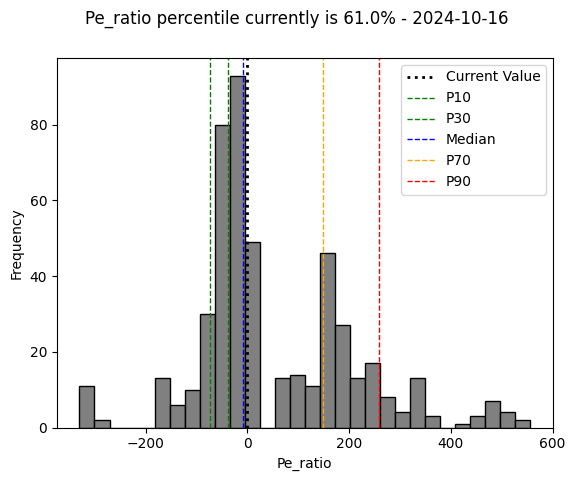

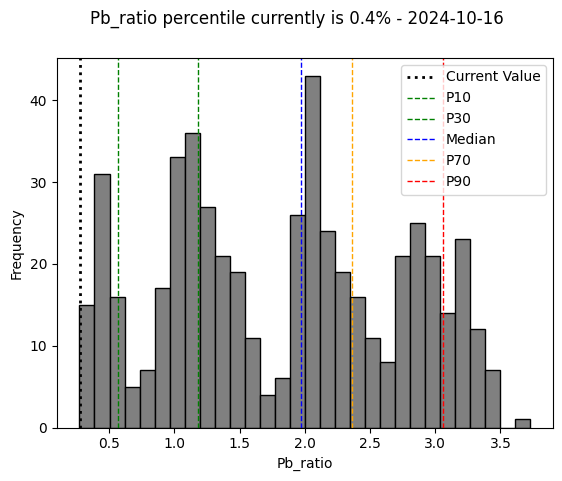

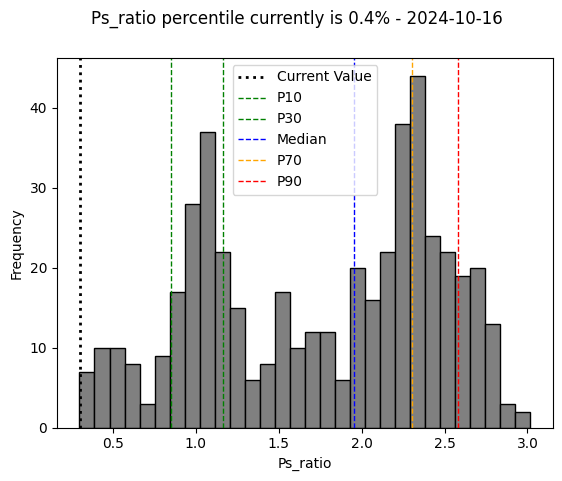

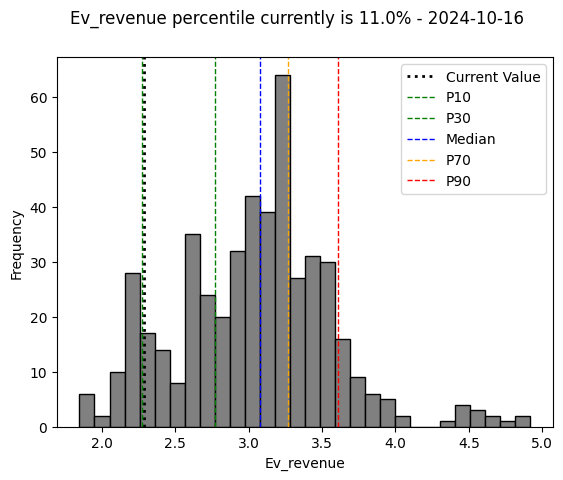

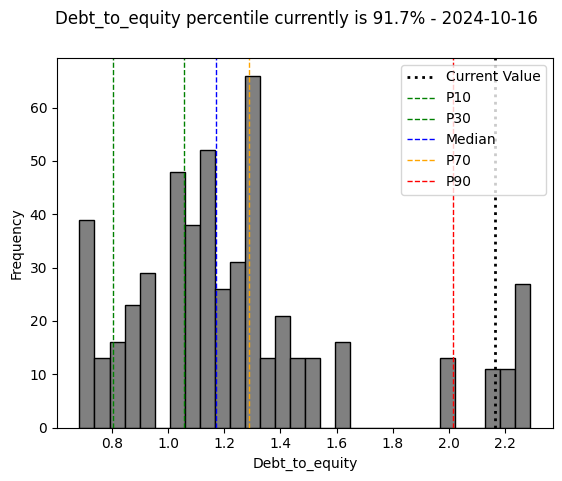

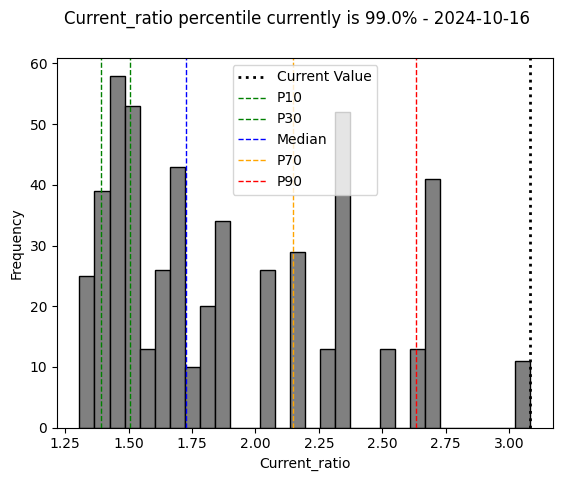

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.978789,0.439235,0.676206,0.603181,-0.011499,-0.706066,-0.178273
roe,0.978789,1.000000,0.353594,0.677983,0.646914,-0.015293,-0.787854,-0.323048
pe_ratio,0.439235,0.353594,1.000000,0.063234,-0.082228,-0.335865,-0.066580,0.025465
pb_ratio,0.676206,0.677983,0.063234,1.000000,0.919104,0.323162,-0.694052,-0.026024
ps_ratio,0.603181,0.646914,-0.082228,0.919104,1.000000,0.462080,-0.815533,-0.153484
ev_revenue,-0.011499,-0.015293,-0.335865,0.323162,0.462080,1.000000,0.017515,0.129980
debt_to_equity,-0.706066,-0.787854,-0.066580,-0.694052,-0.815533,0.017515,1.000000,0.319218
current_ratio,-0.178273,-0.323048,0.025465,-0.026024,-0.153484,0.129980,0.319218,1.000000


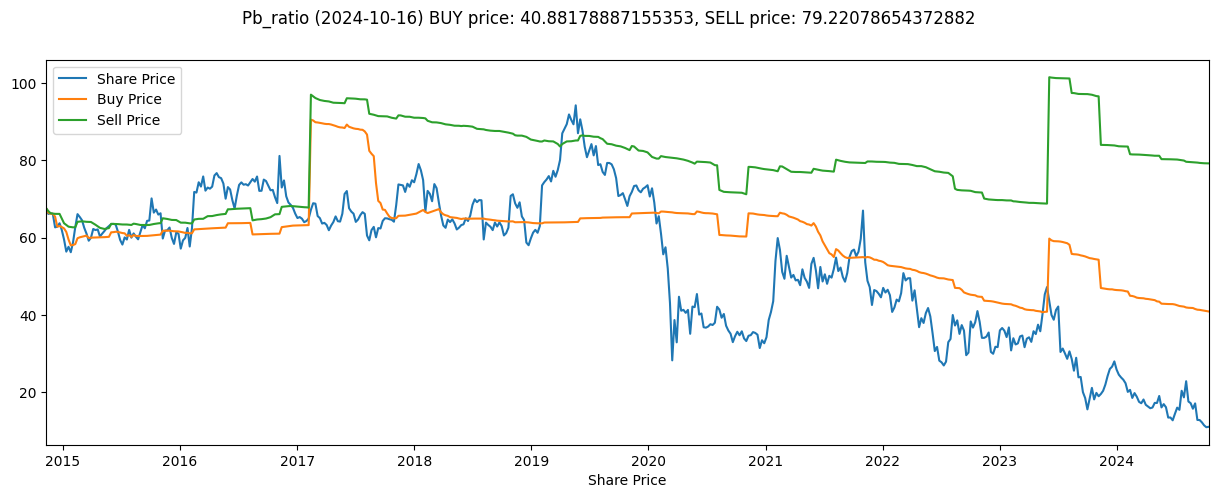

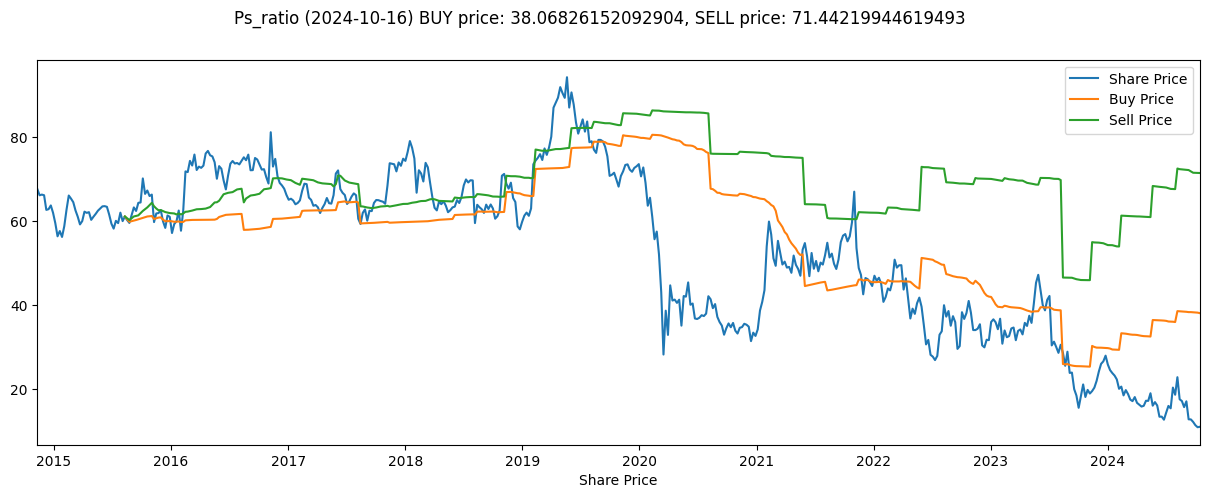

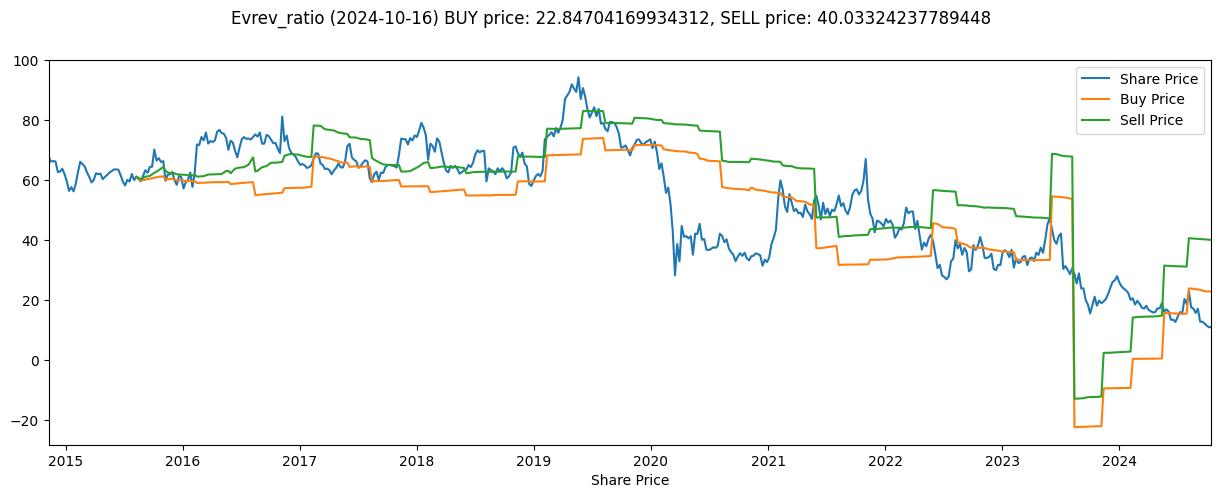

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)